Regressiemodel op de CRUNCHR-data

Wat is een Regressiemodel?
Een regressiemodel is een statistische techniek die gebruikt wordt om de relatie tussen variabelen te begrijpen en voorspellingen te maken. Het model kijkt naar hoe één of meerdere onafhankelijke variabelen (zoals ervaring of functieniveau) invloed hebben op een afhankelijke variabele, bijvoorbeeld het salaris. Door deze verbanden te onderzoeken, kunnen we beter begrijpen hoe bepaalde factoren een waarde beïnvloeden en toekomstige waarden voorspellen.

Het regressiemodel geeft niet alleen aan of er een verband is, maar laat ook zien hoe sterk dit verband is. In eenvoudige woorden, het helpt ons te zien welke factoren het meest bijdragen aan bijvoorbeeld hogere of lagere salarissen en hoeveel deze factoren kunnen verklaren van de variatie in de data.

De prestaties van het model worden beoordeeld aan de hand van de volgende maatstaven:

Mean Squared Error (MSE): De MSE meet hoe groot de gemiddelde fout is tussen de werkelijke en voorspelde waarden. Hoe lager de MSE, hoe nauwkeuriger het model is.

R² (R-squared): Dit getal geeft aan hoeveel van de variatie in de afhankelijke variabele (zoals salaris) wordt verklaard door het model. Een R²-waarde dichter bij 1 betekent dat het model goed verklaart.

In [3]:
#Eerst pandas importeren om er mee te werken
import pandas as pd

#Importeren numpy
import numpy as np

#Importern van mattplotlib 
import matplotlib.pyplot as plt

# maak een dataframe van het bestand data.csv en splits de data per ;
df = pd.read_csv('data.csv')

In [4]:
print(df)

      First name       Last name            Position title  \
0        Viviana  's Gravensande           Sales Associate   
1         Carrol  's Gravensande         Financial Analyst   
2         Amalie  's Gravensande         Financial Analyst   
3      Viridiana  's Gravensande    Airport Services Agent   
4          Shara  's Gravensande    Communications Officer   
...          ...             ...                       ...   
27280   Danyelle         Étienne           Airline Captain   
27281   Mechelle         Étienne          Flight Attendant   
27282      Rhoda         Étienne  Cargo Operations Officer   
27283     Colvin         Étienne             Sales Manager   
27284       Erik         Étienne                      Cook   

                      Full name        Age  Base pay (full-time)  \
0        Viviana 's Gravensande  31.166667          29989.765171   
1         Carrol 's Gravensande  44.666667          70506.994176   
2         Amalie 's Gravensande  37.250000         

Hieronder begin ik met enkele regressiemodel te testen op de groep piloten

Correlatiematrix
Een correlatiematrix is een tabel die de correlatiecoëfficiënten tussen verschillende variabelen in een dataset toont. Elke cel in de matrix geeft aan hoe sterk twee variabelen met elkaar samenhangen. De waarden variëren van -1 tot 1:

1 betekent een perfecte positieve correlatie (als één variabele stijgt, stijgt de andere ook).
-1 betekent een perfecte negatieve correlatie (als één variabele stijgt, daalt de andere).
0 betekent geen verband.

Een correlatiematrix helpt bij het identificeren van welke variabelen mogelijk gerelateerd zijn en kan nuttig zijn om te bepalen welke variabelen geschikt zijn voor verdere analyse of modellering.

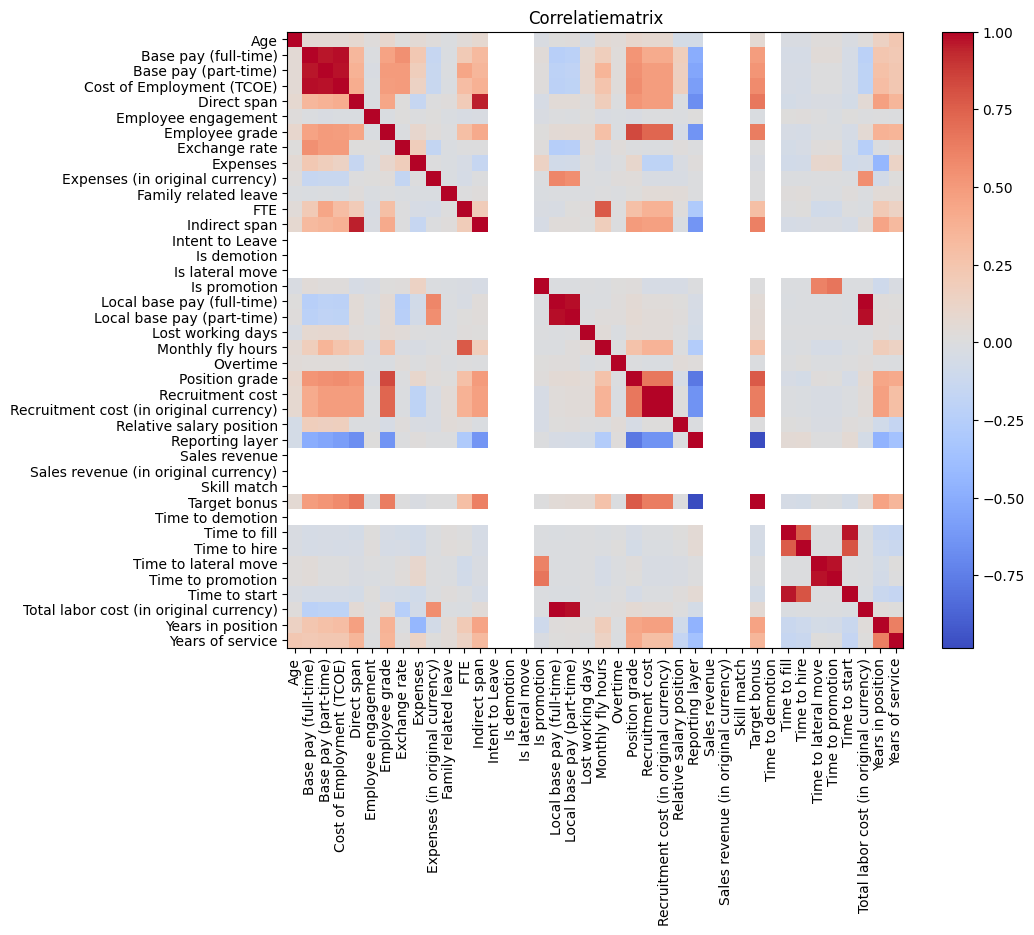

In [5]:
# Correlatiematrix maken om correlatie tussen variabele te vinden

#Datafrane voor enkel piloten maken
piloten_df = df[df['Functional area level 2'] == 'Pilots']

# Alle kolommen met numerieke waarden eruit filteren met functie select_dtypes
nummerieke_kolommen = piloten_df.select_dtypes(include=[np.number])

# Vervangen van alle ontbrekende waarde anders werk correlatiematrix niet met panda functie fillna()
nummerieke_kolommen.fillna(0, inplace=True)

# Berekenen van de colleratie matrix
correlatie_matrix = nummerieke_kolommen.corr()

# Om de Correlatiematrix te testen even printen
#print(correlatie_matrix)

#Matplotlib functies voor visualisatie
plt.figure(figsize=(10, 8))
plt.imshow(correlatie_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

#Bepaal de x en y-as met de waardes van 0 tot de lenge van correlatie_matrix
plt.xticks(range(len(correlatie_matrix)), correlatie_matrix.columns, rotation=90)
plt.yticks(range(len(correlatie_matrix)), correlatie_matrix.columns)
plt.title('Correlatiematrix')
plt.show()


Drempel 0.5
Nu zien wij van alle nummerieke waarden de correlatie, ik heb ervoor gekozen om enkel de waarde te tonen met een hogere correlatie dan 0.5. Door een drempel in te stellen van 0.5, focus ik me alleen op sterke relaties tussen variabelen. Een correlatiecoëfficiënt boven 0.5 betekent dat er sprake is van een matige tot sterke correlatie, wat aangeeft dat de variabelen redelijk sterk met elkaar samenhangen. Met deze drempel filter ik de zwakkere correlaties eruit, zodat ik me kan richten op variabelen die waarschijnlijk meer betekenisvolle verbanden laten zien.

In [6]:
# Dit is de drempel voor significante correlaties
drempel = 0.5

# Hierdoor filtert die op correlatie boven drempel en niet gelijk aan 1
bijzondere_correlaties = correlatie_matrix[(correlatie_matrix.abs() > drempel) & (correlatie_matrix != 1)]

# Print de bijzondere correlaties
print("Bijzondere correlaties (boven de drempel van 0.5):")
print(bijzondere_correlaties.dropna(how='all').dropna(axis=1, how='all'))


Bijzondere correlaties (boven de drempel van 0.5):
                                         Base pay (full-time)  \
Base pay (full-time)                                      NaN   
Base pay (part-time)                                 0.962622   
Cost of Employment (TCOE)                            0.980279   
Direct span                                               NaN   
Employee grade                                            NaN   
Exchange rate                                        0.549954   
Expenses (in original currency)                           NaN   
FTE                                                       NaN   
Indirect span                                             NaN   
Is promotion                                              NaN   
Local base pay (full-time)                                NaN   
Local base pay (part-time)                                NaN   
Monthly fly hours                                         NaN   
Position grade                         

Hierboven zijn alle correlaties weergegeven die een sterk verband laten zien (boven de drempel van 0.5). Op deze geselecteerde correlaties voer ik vervolgens regressieanalyses uit om de relaties verder te onderzoeken.

Ik ga nu op twee variabele die een sterk verband hebben met Salaris voltijd een regressie analyse uitvoeren. Deze ga ik eerst uitvoeren om uit te zoeken welke een goede regressie tonen. In de stap hierna ga ik dit ook daadwerkelijk visualiseren.

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Waarschuwingen uitzetten voor betere leesbaarheid
warnings.filterwarnings("ignore", category=UserWarning, append=True)

# Filter voor piloten
piloten_df = df[df['Functional area level 2'] == 'Pilots']

# Selecteer numerieke kolommen
numerieke_kolommen = piloten_df.select_dtypes(include=[np.number])

# Vul ontbrekende waarden met 0
nummerieke_kolommen = numerieke_kolommen.fillna(0)

# Correlatiematrix berekenen
correlatie_matrix = nummerieke_kolommen.corr()

# Doelvariabele
target = 'Base pay (full-time)'

# Door alle kolommen die een correlatie > 0.5 hebben met het salaris
for kolom in correlatie_matrix.columns:
    if kolom != target:
        correlatie = correlatie_matrix.loc[target, kolom]
        if abs(correlatie) > 0.5:
            # Regressiemodel maken met deze variabele
            X = nummerieke_kolommen[[kolom]]
            y = nummerieke_kolommen[target]

            # Data splitsen in training en test
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Lineaire regressie trainen
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Voorspellingen maken
            y_pred = model.predict(X_test)

            # MSE en R2 berekenen
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Resultaten printen
            print(f"\nRegressiemodel voor: {kolom} vs {target}")
            print(f"Correlatie: {correlatie:.2f}")
            print(f"Mean Squared Error (MSE): {mse:.2f}")
            print(f"R-squared (R²): {r2:.2f}")


Regressiemodel voor: Base pay (part-time) vs Base pay (full-time)
Correlatie: 0.96
Mean Squared Error (MSE): 86418823.90
R-squared (R²): 0.92

Regressiemodel voor: Cost of Employment (TCOE) vs Base pay (full-time)
Correlatie: 0.98
Mean Squared Error (MSE): 57644486.38
R-squared (R²): 0.95

Regressiemodel voor: Exchange rate vs Base pay (full-time)
Correlatie: 0.55
Mean Squared Error (MSE): 781527325.60
R-squared (R²): 0.28

Regressiemodel voor: Position grade vs Base pay (full-time)
Correlatie: 0.52
Mean Squared Error (MSE): 799419408.12
R-squared (R²): 0.26


In dit geval zijn het Salaris voltijd en Salaris deeltijd en Salaris voltijd en Cost of Employment die een goede regressie tonen, deze ga ik hieronder visualiseren. 

De correlaties die ik gevonden heb, zijn goed te verklaren. Het verband tussen Base pay (part-time) en Base pay (full-time) (correlatie 0.96) is logisch, omdat beide salarisstructuren dezelfde schaal volgen. Part-time salarissen zijn meestal een percentage van full-time salarissen, waardoor de twee sterk aan elkaar gekoppeld zijn.

De hoge correlatie tussen Base pay (full-time) en Cost of Employment (TCOE) (correlatie 0.98) is ook verwacht. De totale arbeidskosten omvatten het salaris van een medewerker, dus een hoger basisloon leidt direct tot hogere totale kosten. Dit verklaart de sterke relatie tussen deze twee variabelen.

Regressiemodel voor: Base pay (full-time) vs Position grade
Mean Squared Error (MSE): 430947488.12
R-squared (R²): 0.47



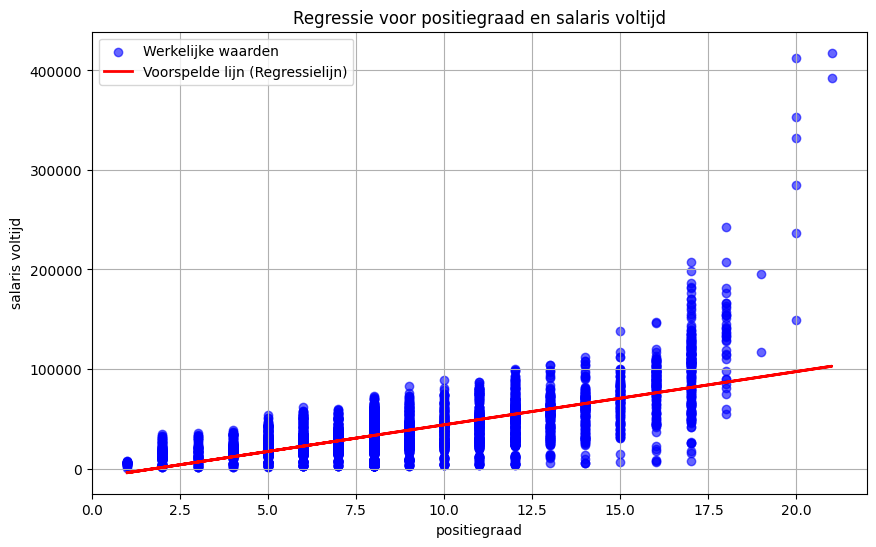

Regressiemodel voor: Base pay (full-time) vs Cost of Employment (TCOE)
Mean Squared Error (MSE): 41337581.17
R-squared (R²): 0.95



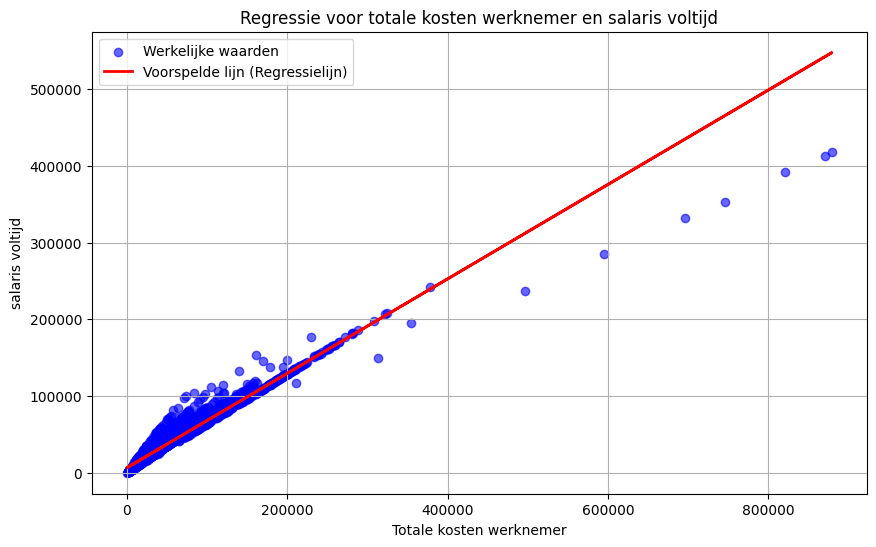

In [11]:
# Functie om een lineair model te trainen en visualiseren
def train_and_visualize(x_column, y_column, xlabel, ylabel, title):
    X = df[[x_column]]
    y = df[y_column]

    # Data splitsen in training en test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Lineair regressiemodel trainen
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Voorspellen van de testset
    y_pred = model.predict(X_test)

    # Evalueren van het model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print de resultaten
    print(f"Regressiemodel voor: {y_column} vs {x_column}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.2f}\n")

    # Visualisatie van het model
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', label='Werkelijke waarden', alpha=0.6)
    plt.plot(X_test, y_pred, color='red', label='Voorspelde lijn (Regressielijn)', linewidth=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#Visualisatie voor positiegraad vs Base pay (full-time)
train_and_visualize(
    x_column='Position grade',
    y_column='Base pay (full-time)',
    xlabel='positiegraad',
    ylabel='salaris voltijd',
    title='Regressie voor positiegraad en salaris voltijd'
)

# Visualisatie voor Cost of Employment (TCOE) vs Base pay (full-time)
train_and_visualize(
    x_column='Cost of Employment (TCOE)',
    y_column='Base pay (full-time)',
    xlabel='Totale kosten werknemer',
    ylabel='salaris voltijd',
    title='Regressie voor totale kosten werknemer en salaris voltijd'
)


De visualisaties laten duidelijk het verschil in voorspellingskracht zien: in de grafiek voor *Cost of Employment (TCOE)* liggen de blauwe punten (werkelijke waarden) dicht bij de rode regressielijn, wat wijst op een sterke overeenkomst en hoge R² van 0.95. In de grafiek voor *Position grade* is er veel meer spreiding van de blauwe punten rond de rode lijn, wat visueel bevestigt dat dit model minder nauwkeurig is met een lagere R² van 0.47. Hierdoor zie je dat *TCOE* visueel en statistisch een sterkere voorspeller van het salaris is dan de positiegradatie.